# Import Modules

In [1]:
%load_ext autoreload
%autoreload 2

import os
import argparse
import glob
import sys 
import yaml 
import glob

import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.backends.backend_pdf import PdfPages

from scipy import interpolate 
from scipy import signal

from pathlib import Path
sys.path.append(str(Path('.').absolute().parent.parent))
from util.paths import find, list_subdirs

import matplotlib as mpl
mpl.rcParams.update({'font.size':         24,
                     'axes.linewidth':    3,
                     'xtick.major.size':  5,
                     'xtick.major.width': 2,
                     'ytick.major.size':  5,
                     'ytick.major.width': 2,
                     'axes.spines.right': False,
                     'axes.spines.top':   False,
                     'font.sans-serif':  "Arial",
                     'font.family':      "sans-serif",
                    })
# pd.set_option('display.max_rows', None)

import platform
if platform.system() == 'Linux':
    base_path = Path('~/NewMonster/T/BinocOptoPreyCapture/').expanduser()
    print('Running on Linux')
else:
    base_path = Path('T:/BinocOptoPreyCapture').expanduser()
    print('Running on Windows')

Running on Linux


In [2]:

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

def add_colorbar(mappable,linewidth=2):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(mappable, cax=cax, drawedges=False)
    cbar.outline.set_linewidth(linewidth)
    plt.sca(last_axes)
    return cbar

# Load CSV Files and Meta Data

In [3]:
# csv_filepath = os.path.normpath('T:/OptoPreyCapture/csv_today.csv')
csv_filepath = base_path / 'csv_testing.csv'
csv = pd.read_csv(csv_filepath)
csv['experiment_date'] = pd.to_datetime(csv['experiment_date'],infer_datetime_format=True,format='%m%d%Y').dt.strftime('%m%d%y')
csv = csv.loc[(csv['run_preprocessing'] == True)|(csv['run_ephys_analysis'] == True)]
csv = csv[csv['experiment_outcome']=='good'].reset_index(drop=True)
# Format Pandas Dataframe to have Trial number and Stimulus condition

cols = list(csv.keys()[:-4])
cols.append('Trial')
cols.append('LaserOn')
csv2 = pd.DataFrame(columns=cols)
for ind,row in csv.iterrows():
    for n in range(1,6):
        if '*' in row['{:d}'.format(n)]:
            csv2 = csv2.append(row[:-4].append(pd.Series([n,True],index=['Trial','LaserOn'])),ignore_index=True)
        else:
            csv2 = csv2.append(row[:-4].append(pd.Series([n,False],index=['Trial','LaserOn'])),ignore_index=True)
inds, labels = csv2['Environment'].factorize()

In [4]:
row = csv2.iloc[n]
fname = str(list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*_BasicParams.h5'))[0])
with pd.HDFStore(fname) as store:
    data = store['df']
    metadata = store.get_storer('df').attrs.metadata

In [5]:
df_meta = pd.DataFrame(columns=list(metadata.keys()))
for ind, row in csv2.iterrows():
    if list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*_BasicParams.h5')) != []:
        fname = str(list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*_BasicParams.h5'))[0])
        with pd.HDFStore(fname) as store:
            data = store['df']
            metadata = store.get_storer('df').attrs.metadata
            metadata.update(csv2[['animal_name','experiment_date','Trial','LaserOn','Environment','Exp_Ctrl']].iloc[ind])
            df_meta = df_meta.append(metadata, ignore_index=True)

## Plotting by Conditions

In [70]:
df_meta.head()

,MovieT,CaptureT,TimeToApproach,FreqApproach,ProbInter,ProbCapture,dist_at_fapproach,animal_name,experiment_date,Trial,LaserOn,Environment,Exp_Ctrl
0,24.883333,20.366667,2.400857,0.643001,0.750000,0.083333,13.839170,PVCha2black,082421,1,True,Lno,Exp
1,64.000000,63.766667,11.469606,0.343750,0.727273,0.062500,9.620748,PVCha2black,082421,2,True,Lno,Exp
2,27.116667,21.516667,5.334464,0.295022,0.625000,0.200000,39.198793,PVCha2black,082421,3,True,Lno,Exp
3,42.683333,39.183333,0.683968,0.281140,0.083333,1.000000,32.296246,PVCha2black,082421,4,False,Lno,Exp
4,76.133333,76.116667,2.484109,0.341506,0.115385,0.333333,14.713744,PVCha2black,082421,5,True,Lno,Exp


In [67]:
df_mean = df_meta.groupby(['experiment_date','LaserOn','Environment','Exp_Ctrl']).median()

In [68]:
df_mean

MovieT   CaptureT  \
experiment_date LaserOn Environment Exp_Ctrl                         
082421          False   Lno         Ctrl      53.583333  49.200000   
                                    Exp       59.250000  59.233333   
                True    Lno         Ctrl      62.916667  59.916667   
                                    Exp       63.475000  63.341667   
082521          False   Hsb         Ctrl      47.725000  44.591667   
                                    Exp       61.283333  60.833333   
                True    Hsb         Ctrl      43.800000  40.700000   
                                    Exp       62.608333  61.783333   
082621          False   Wno         Ctrl      13.358333   9.716667   
                                    Exp       22.183333  18.958333   
                True    Wno         Ctrl      17.983333  12.116667   
                                    Exp       32.150000  27.291667   
082721          False   Hno         Ctrl      36.183333  33.625000   
                                    Exp       37.975000  35.825000   
                True    Hno         Ctrl      21.400000  18.000000   
                                    Exp       48.183333  45.483333   
083021          False   Lsb         Ctrl      32.816667  30.716667   
                                    Exp       59.850000  59.833333   
                True    Lsb         Ctrl      44.083333  42.633333   
                                    Exp       51.550000  48.066667   
083121          False   Lno         Ctrl       9.500000   7.158333   
                                    Exp       46.066667  41.358333   
                True    Lno         Ctrl      11.550000   8.883333   
                                    Exp       44.700000  42.733333   
090121          False   Wsw         Ctrl      27.841667  21.650000   
                                    Exp       25.866667  22.700000   
                True    Wsw         Ctrl      22.333333  17.466667   
                                    Exp       42.891667  37.950000   
090221          False   Wsb         Ctrl      31.900000  30.700000   
                                    Exp       42.958333  41.791667   
                True    Wsb         Ctrl      34.283333  31.316667   
                                    Exp       49.508333  48.866667   

                                              TimeToApproach  FreqApproach  \
experiment_date LaserOn Environment Exp_Ctrl                                 
082421          False   Lno         Ctrl            2.800844      0.373250   
                                    Exp             4.818701      0.281140   
                True    Lno         Ctrl            5.559564      0.273066   
                                    Exp             4.876192      0.196769   
082521          False   Hsb         Ctrl            2.683335      0.392544   
                                    Exp             5.835072      0.264718   
                True    Hsb         Ctrl            3.967552      0.344828   
                                    Exp             2.934176      0.273916   
082621          False   Wno         Ctrl            2.092551      0.378417   
                                    Exp             2.084115      0.412848   
                True    Wno         Ctrl            3.200627      0.331797   
                                    Exp             5.902522      0.223100   
082721          False   Hno         Ctrl            2.425415      0.414561   
                                    Exp             2.242087      0.315165   
                True    Hno         Ctrl            1.851123      0.424028   
                                    Exp             3.716659      0.276266   
083021          False   Lsb         Ctrl            3.818086      0.322482   
                                    Exp             2.084403      0.273438   
                True    Lsb         Ctrl            1.283827      0.375510   
                              

In [ ]:
plt.bar()

In [21]:
df_mean.xs(('Ctrl'), level=(3))

MovieT   CaptureT  TimeToApproach  \
experiment_date LaserOn Environment                                         
082421          False   Lno          53.794444  50.411111       13.393122   
                True    Lno          53.215278  50.447222        8.166390   
082521          False   Hsb          47.091667  45.002778        2.706257   
                True    Hsb          42.770370  40.561111        6.855919   
082621          False   Wno          16.163889  11.952778        2.342545   
                True    Wno          16.942593  12.759259        3.871869   
082721          False   Hno          32.422222  29.672222        2.156267   
                True    Hno          28.453704  25.683333        3.213939   
083021          False   Lsb          35.547222  33.419444        3.901491   
                True    Lsb          41.622222  39.400000        1.382310   
083121          False   Lno           9.744444   7.658333        1.667330   
                True    Lno          20.761111  17.281481        2.641661   
090121          False   Wsw          24.975000  20.333333        5.513329   
                True    Wsw          22.590741  17.983333        3.651248   
090221          False   Wsb          31.900000  30.700000        1.750970   
                True    Wsb          35.922222  33.044444        6.912644   

                                     FreqApproach  ProbInter  ProbCapture  \
experiment_date LaserOn Environment                                         
082421          False   Lno              0.314419   0.632051     0.122896   
                True    Lno              0.292304   0.419499     0.276025   
082521          False   Hsb              0.398676   0.333601     0.216667   
                True    Hsb              0.318947   0.370505     0.343827   
082621          False   Wno              0.406626   0.864394     0.230628   
                True    Wno              0.348919   0.847707     0.300926   
082721          False   Hno              0.442924   0.625031     0.125595   
                True    Hno              0.402220   0.578753     0.210494   
083021          False   Lsb              0.330235   0.382920     0.341865   
                True    Lsb              0.368547   0.405667     0.320727   
083121          False   Lno              0.474324   0.787500     0.418254   
                True    Lno              0.320131   0.588718     0.565873   
090121          False   Wsw              0.259173   0.606209     0.409722   
                True    Wsw              0.294399   0.633478     0.387302   
090221          False   Wsb              0.275866   0.715278     0.171429   
                True    Wsb              0.213431   0.756410     0.227778   

                                     dist_at_fapproach  
experiment_date LaserOn Environment                     
082421          False   Lno                   8.250512  
                True    Lno                  25.085399  
082521          False   Hsb                  16.185303  
                True    Hsb                  20.538119  
082621          False   Wno                  23.226413  
                True    Wno                  18.692082  
082721          False   Hno                  22.407312  
                True    Hno                  18.922233  
083021          False   Lsb                  26.903152  
                True    Lsb                  16.915126  
083121          False   Lno                  14.253351  
                True    Lno                  16.491697  
090121          False   Wsw                  21.181074  
                True    Wsw                  19.244413  
090221          False   Wsb                  19.425855  
                True    Wsb                  18.718997

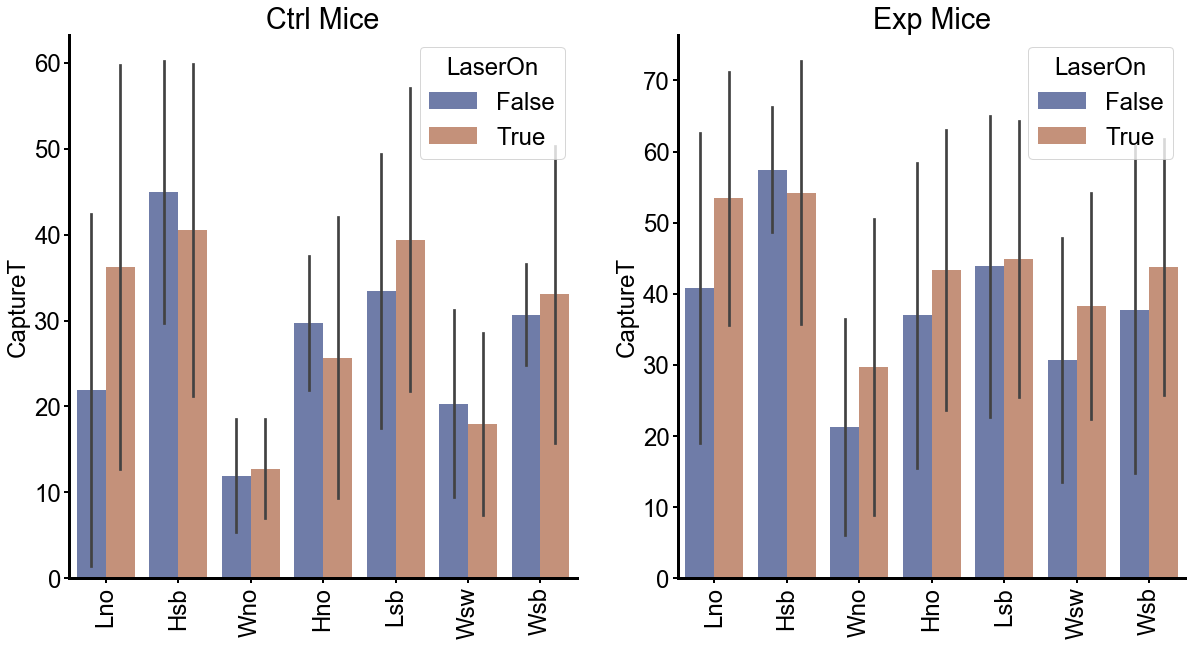

In [65]:
Metric = 'CaptureT'
fig, axs = plt.subplots(1,2,figsize=(20,10))
for ind, cond in enumerate(np.unique(df_meta['Exp_Ctrl'])):
    g = sns.barplot(data=df_meta[df_meta['Exp_Ctrl']==cond], x="Environment", y=Metric, hue="LaserOn",
                    ci='sd', palette="dark", alpha=.6, ax=axs[ind])
    g.set_xlabel("")
    g.set_ylabel("{}".format(Metric))
    g.set_xticklabels(g.get_xticklabels(), rotation = 90)
    g.set_title('{} Mice'.format(cond))

# g2 = sns.barplot(data=df_meta[df_meta['Exp_Ctrl']=='Exp'], x="Environment", y="CaptureT", hue="LaserOn",
#                 ci='sd', palette="dark", alpha=.6, ax=axs[1])
# g2.set_xlabel("")
# g2.set_ylabel("Prob of Capture")
# # g2.set_ylim([0,1])
# g2.set_xticklabels(g.get_xticklabels(), rotation = 90)
# g2.set_title('Exp Mice')

# Opto Laser

In [176]:
from scipy.signal import medfilt

In [182]:
csv2[['animal_name','experiment_date','Trial','LaserOn']]

,animal_name,experiment_date,Trial,LaserOn
0,PVCha2black,082521,1,True
1,PVCha2black,082521,2,False
2,PVCha2black,082521,3,False
3,PVCha2black,082521,4,True
4,PVCha2black,082521,5,True
...,...,...,...,...
355,PV154black,090321,1,True
356,PV154black,090321,2,True
357,PV154black,090321,3,False
358,PV154black,090321,4,False


In [177]:

date = '082521'
ani = 'PVCha2green'
trial = 1
fname = str(list((base_path /date / ani /'{:d}'.format(trial)).glob('*imu.nc'))[0])
imu_data = xr.open_dataset(fname)
LaserT = imu_data.IMU_data.sample.data # imu timestamps
LaserT0 = LaserT[0]
LaserT = LaserT - LaserT0
laser = imu_data.IMU_data.sel(channel='acc_x_raw').data # imu dample data
dlaser = np.diff(medfilt(laser, kernel_size=15),append=np.nan)
LOnOff = (np.argmax(dlaser), np.argmin(dlaser))

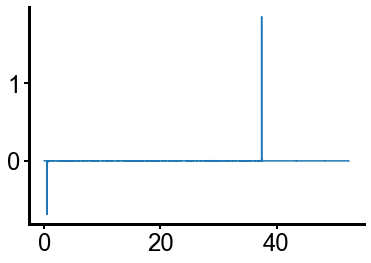

In [175]:
plt.plot(LaserT,dlaser)

In [149]:
LaserTimes[0],LaserTimes[-1]

(9268, 9268)

In [ ]:
plt.plot(medfilt(laser, kernel_size=15))

In [108]:
df_all = pd.DataFrame()
for ind, row in csv2.iterrows():
    if list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*imu.nc')) != []:
        fname = str(list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*imu.nc'))[0])
        

# Checking Basic Params

In [201]:
import platform
if platform.system() == 'Linux':
    base_path = Path('~/NewMonster/T/BinocOptoPreyCapture/').expanduser()
    print('Running on Linux')
else:
    base_path = Path('T:/BinocOptoPreyCapture').expanduser()
    print('Running on Windows')
csv_filepath = base_path / 'csv_testing.csv'
csv = pd.read_csv(csv_filepath)
csv['experiment_date'] = pd.to_datetime(csv['experiment_date'],infer_datetime_format=True,format='%m%d%Y').dt.strftime('%m%d%y')
csv = csv.loc[(csv['run_preprocessing'] == True)|(csv['run_ephys_analysis'] == True)]
csv = csv[csv['experiment_outcome']=='good'].reset_index(drop=True)
# Format Pandas Dataframe to have Trial number and Stimulus condition

cols = list(csv.keys()[:-4]) # Take every column but last 4 which is computer info
cols.append('Trial')
cols.append('LaserOn')
csv2 = pd.DataFrame(columns=cols)
for ind,row in csv.iterrows():
    for n in range(1,5): # Trials 1-5
        if '*' in row['{:d}'.format(n)]:
            csv2 = csv2.append(row[:-4].append(pd.Series([n,True],index=['Trial','LaserOn'])),ignore_index=True)
        else:
            csv2 = csv2.append(row[:-4].append(pd.Series([n,False],index=['Trial','LaserOn'])),ignore_index=True)
inds, labels = csv2['Environment'].factorize()

n = 0
row = csv2.iloc[n]
topfile = str(list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*Top1.nc'))[0])
imufile = str(list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*imu.nc'))[0])

animal_dir = (os.path.normpath(os.path.join(row['drive']+':/','BinocOptoPreyCapture',row['experiment_date'],row['animal_name'])))
config_path = os.path.normpath(os.getcwd()+'\project_analysis\prey_capture\config.yaml')
with open(config_path, 'r') as infile:
    config = yaml.load(infile, Loader=yaml.FullLoader)
config['animal_dir'] = animal_dir
# calc_params(config)

IndexError: list index out of range

In [200]:
row

animal_name                                       PVCha2black
experiment_date                                        082521
Unnamed: 2                                                NaN
Weight                                                   24.4
1                                                          x*
2                                                           x
3                                                        0:52
4                                                       1:00*
5                                                       1:08*
Exp_Ctrl                                                  Exp
Deprived                                                  yes
Environment                                               Hsb
Laser                                                       y
Notes                                                  [2, 3]
Cricket_size          really itchy left ear at end of trial 5
excluded_trials                                           NaN
experime

In [186]:
row = csv2.iloc[0]
csv2.head()


,animal_name,experiment_date,Unnamed: 2,Weight,1,2,3,4,5,Exp_Ctrl,...,Laser,Notes,Cricket_size,excluded_trials,experiment_outcome,computer,drive,run_preprocessing,Trial,LaserOn
0,PVCha2black,082521,NaN,24.4,x*,x,0:52,1:00*,1:08*,Exp,...,y,"[2, 3]",really itchy left ear at end of trial 5,NaN,good,new-monster,T,True,1,True
1,PVCha2black,082521,NaN,24.4,x*,x,0:52,1:00*,1:08*,Exp,...,y,"[2, 3]",really itchy left ear at end of trial 5,NaN,good,new-monster,T,True,2,False
2,PVCha2black,082521,NaN,24.4,x*,x,0:52,1:00*,1:08*,Exp,...,y,"[2, 3]",really itchy left ear at end of trial 5,NaN,good,new-monster,T,True,3,False
3,PVCha2black,082521,NaN,24.4,x*,x,0:52,1:00*,1:08*,Exp,...,y,"[2, 3]",really itchy left ear at end of trial 5,NaN,good,new-monster,T,True,4,True
4,PVCha2black,082521,NaN,24.4,x*,x,0:52,1:00*,1:08*,Exp,...,y,"[2, 3]",really itchy left ear at end of trial 5,NaN,good,new-monster,T,True,5,True


In [184]:
fname = str(list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*TOP1.nc'))[0])
fname

'/home/seuss/NewMonster/T/BinocOptoPreyCapture/082521/PVCha2black/1/082521_PVCha2black_y_Hsb_1_TOP1.nc'

In [195]:
pixpercm = 14.5
thresh = 0.99
framerate = 60
# load all of data in file
data = xr.open_dataset(fname)

# load DLC points for mouse
Cricket_p = data['TOP1_pts'].sel(point_loc='Cricket1_likelihood').data
Rear_x = data['TOP1_pts'].sel(point_loc='Rear_x').data/pixpercm
Rear_y = data['TOP1_pts'].sel(point_loc='Rear_y').data/pixpercm
Rear_xy=np.asarray([Rear_x, Rear_y])
Lear_x = data['TOP1_pts'].sel(point_loc='Lear_x').data/pixpercm
Lear_y = data['TOP1_pts'].sel(point_loc='Lear_y').data/pixpercm
Lear_xy=np.asarray([Lear_x, Lear_y])
mouse_xy=0.5*(Rear_xy+Lear_xy)

# load DLC points for cricket
Cricket_x = (data['TOP1_pts'].sel(point_loc='Cricket1_x').data+data['TOP1_pts'].sel(point_loc='Cricket2_x').data)/2
Cricket_y = (data['TOP1_pts'].sel(point_loc='Cricket1_y').data+data['TOP1_pts'].sel(point_loc='Cricket2_y').data)/2
Cricket_x=Cricket_x/pixpercm
Cricket_y=Cricket_y/pixpercm
crick_x_thresh = Cricket_x.copy()
crick_x_thresh[Cricket_p < thresh] = np.nan
crick_y_thresh = Cricket_y.copy()
crick_y_thresh[Cricket_p < thresh] = np.nan
Cricket_xy=[crick_x_thresh, crick_y_thresh]

#interpolate values to fill NaNs
ind = np.arange(0,len(crick_x_thresh))
interp = interpolate.interp1d(ind[~np.isnan(crick_x_thresh)], crick_x_thresh[~np.isnan(crick_x_thresh)],bounds_error=False, fill_value=np.nan )
cricket_x_interp = interp(ind)

ind = np.arange(0,len(crick_y_thresh))
interp = interpolate.interp1d(ind[~np.isnan(crick_y_thresh)], crick_y_thresh[~np.isnan(crick_y_thresh)],bounds_error=False, fill_value=np.nan)
cricket_y_interp = interp(ind)

#calculate time to capture, currently not the best, think there is a tradeoff between having the thresh low enough that speed and range look better and getting the exact time to capture
captureT = np.max(np.where(~np.isnan(Cricket_xy[0])))/framerate # return this
movieT = len(Cricket_p)/framerate
if captureT.size==0:
    captureT = movieT

# calculate and plot distance between mouse and cricket
timestamps = np.asarray(data['timestamps'])
t = timestamps-timestamps[0]
dist = np.sqrt(np.square(crick_x_thresh- mouse_xy[0]) + np.square(crick_y_thresh - mouse_xy[1])) #cmn - changes to cricket_x instead of interp.
dist[-1] = 0  # we know that last point should be 0 range, since it's capture

# more interpolation!!!
ind = np.arange(0,len(dist))
interp = interpolate.interp1d(ind[~np.isnan(dist)], dist[~np.isnan(dist)],bounds_error=False, fill_value=np.nan )
range_interp = interp(ind)
dist = range_interp

# calculate mouse speed
speed_win = 12
dx = np.diff(mouse_xy[0],prepend=np.nan)
dx = np.convolve(dx,np.ones(speed_win)/win, 'same')
dy = np.diff(mouse_xy[1],prepend=np.nan)
dy = np.convolve(dy,np.ones(speed_win)/win, 'same')
spd = (np.sqrt(np.square(dx)+np.square(dy)))*framerate

# calculate azimuth 
mouse_az = np.arctan2((Cricket_xy[1] - mouse_xy[1]),(Cricket_xy[0] - mouse_xy[0]))*180/np.pi
head_az = np.arctan2((Rear_xy[1] - Lear_xy[1]),(Rear_xy[0] - Lear_xy[0]))*180/np.pi -90
az = mouse_az-head_az
az = np.mod(az+180,360)-180
if np.sum(~np.isnan(az))>0:
    azOld = az
    ind = np.arange(0,len(az))
    interp = interpolate.interp1d(ind[~np.isnan(az)], az[~np.isnan(az)],bounds_error=False, fill_value=np.nan )
    az = interp(ind)

/tmp/ipykernel_2559071/1428150903.py:67: RuntimeWarning: invalid value encountered in remainder
  az = np.mod(az+180,360)-180


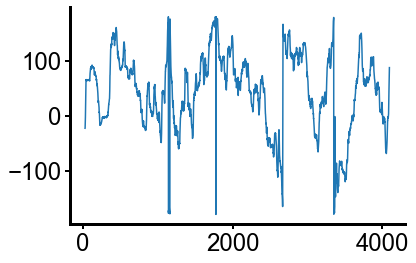

In [194]:
plt.plot(az)


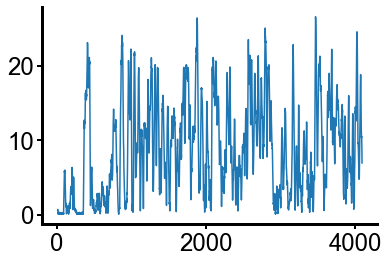

In [197]:
plt.plot(spd)

# HMM/Clustering Testing

In [29]:
import ssm

import plotly.express as px
import plotly.graph_objects as go

In [30]:
df_all = pd.DataFrame()
for ind, row in csv2.iterrows():
    if list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*_BasicParams.h5')) != []:
        fname = str(list((base_path /row['experiment_date'] / row['animal_name'] /'{:d}'.format(row['Trial'])).glob('*_BasicParams.h5'))[0])
        with pd.HDFStore(fname) as store:
            data = store['df']
            data['animal_name'] = row['animal_name']
            data['experiment_date'] = row['experiment_date']
            data['Trial'] = row['Trial']
            data.set_index(['experiment_date','animal_name','Trial'],inplace=True)
            df_all = df_all.append(data)
#             az.append(data['Angle'].values)
#             sp.append(data['Speed'].values)
#             dist.append(data['Dist'].values)
# az = np.hstack(az)/180
# sp = np.hstack(sp)/200
# dist = np.hstack(dist)/40

In [31]:
df_all.head()

Angle  Speed  Dist    Mouse_x   Mouse_y  \
experiment_date animal_name Trial                                            
082421          PVCha2black 1        NaN    NaN   NaN  44.430473  3.550671   
                            1        NaN    NaN   NaN  44.435762  3.524523   
                            1        NaN    NaN   NaN  44.356618  3.525760   
                            1        NaN    NaN   NaN  44.326793  3.560057   
                            1        NaN    NaN   NaN  44.000739  3.643543   

                                   Cricket_x  Cricket_y         t  
experiment_date animal_name Trial                                  
082421          PVCha2black 1            NaN        NaN  0.000000  
                            1            NaN        NaN  0.017856  
                            1            NaN        NaN  0.033446  
                            1            NaN        NaN  0.050124  
                            1            NaN        NaN  0.067251

In [32]:
df = df_all.dropna()
df['Angle'] = df['Angle']/180
df['Speed'] = df['Speed']/200
df['Dist'] = df['Dist']/40

/home/seuss/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [71]:
kclustering = KMeans(n_clusters=6)

<IPython.core.display.Javascript object>

In [72]:
X2 = df[['Angle','Speed','Dist']].values
# X2 = X[~np.isnan(X).any(axis=1)]

In [73]:
labels = kclustering.fit_predict(X2)
df['labels'] = labels

/home/seuss/anaconda3/envs/DEEPLABCUT/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



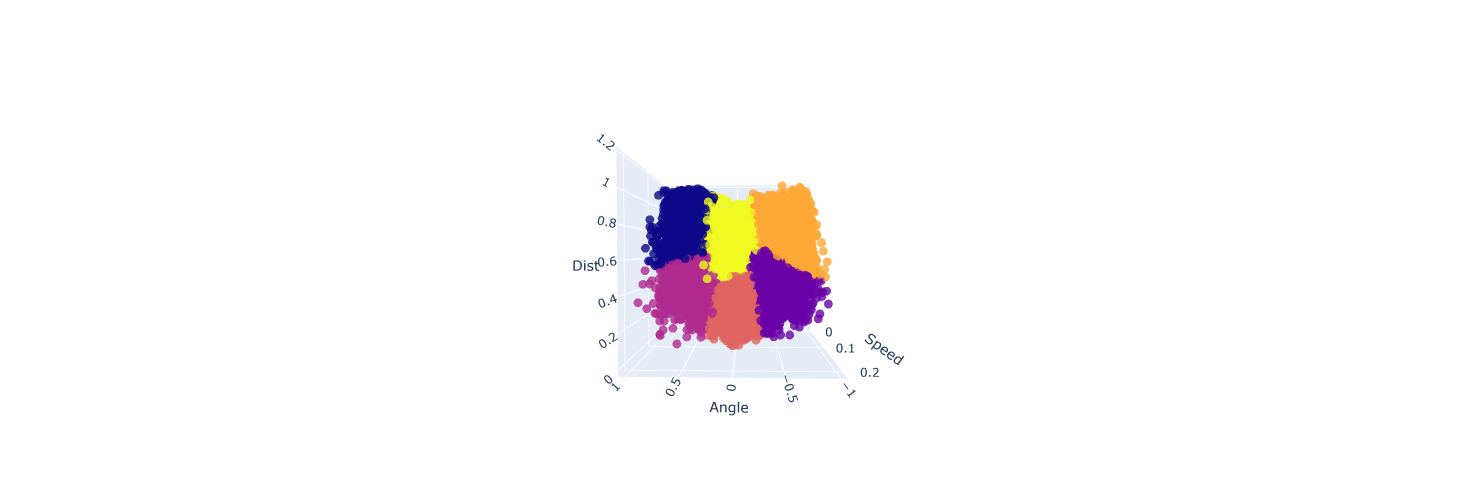

In [74]:

fig = go.Figure(data=[go.Scatter3d(x=X2[::100,0], y=X2[::100,1], z=X2[::100,2],
                                   mode='markers',
                                   marker=dict(
                                                size=5,
                                                color=labels[::100],
#                                                 colorbar=dict(title='Time'),
                                                opacity=0.8),
                                   
                                   )])
fig.update_layout(autosize=False,
#                   coloraxis_colorbar=dict(title='Time (s)'),
                  scene= dict(
                  xaxis_title='Angle',
                  yaxis_title='Speed',
                  zaxis_title='Dist'),
                  width=500,
                  height=500,
                  )
fig.show()

In [79]:
Trial = 1
mx = df.xs(('083121','PVCha2black',Trial),level=(0,1,2))['Mouse_x'].values
my = df.xs(('083121','PVCha2black',Trial),level=(0,1,2))['Mouse_y'].values
cx = df.xs(('083121','PVCha2black',Trial),level=(0,1,2))['Cricket_x'].values
cy = df.xs(('083121','PVCha2black',Trial),level=(0,1,2))['Cricket_y'].values
lab = df.xs(('083121','PVCha2black',Trial),level=(0,1,2))['labels'].values

In [80]:

# cmap = mpl.cm.viridis
# bounds = np.unique(lab)
# norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cmap = mpl.cm.get_cmap("jet", len(np.unique(lab)))

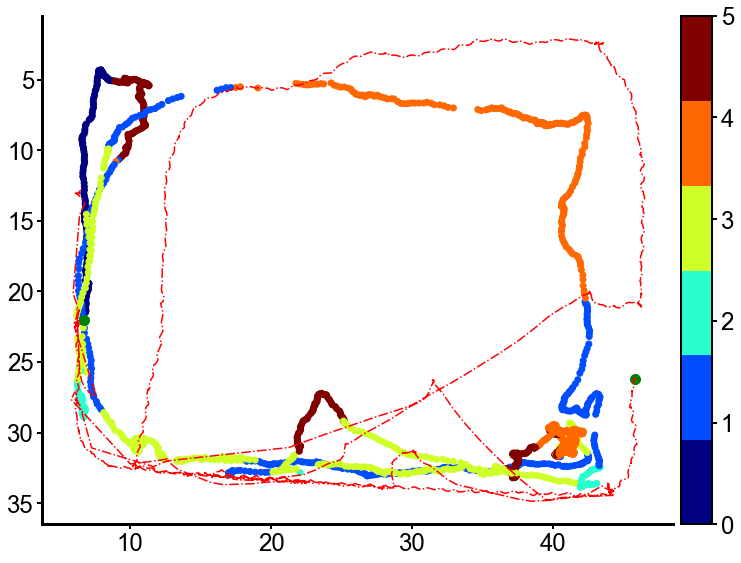

In [81]:
fig, ax = plt.subplots(figsize=(12, 10))
# fig.subplots_adjust(bottom=0.5)

im = ax.scatter(mx,my,c=lab,cmap=cmap)
ax.scatter(mx[0],my[0],c='g',s=100)
ax.scatter(cx[0],cy[0],c='g',s=100)

ax.plot(cx,cy,'r-.')
add_colorbar(im)
ax.set_ylim(ax.get_ylim()[::-1])        # invert the axis
ax.set_aspect('equal', 'box')

Take total amount of time for light on and light off, and divide by # of captures in light on vs light off. Proxy for time to capture

Mean time in each state. Laser mice might have more time in stationary state. Cricket change in velocity/angles. 

laser on vs laser off in geneotype first 30s vs last 30s